In [1]:
import os
import pandas as pd
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
import tensorflow as tf
from keras.callbacks import EarlyStopping

local_path = os.getcwd()

In [2]:
train_data = pd.read_table(os.path.join(local_path, 'data', 'ratings_train.txt'))
test_data = pd.read_table(os.path.join(local_path, 'data', 'ratings_test.txt'))
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
#https://wikidocs.net/44249
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

    
def load_data(train_data, test_data, num_words=10000, split=0.25):
    data_tokend = []
    print("train_len = {}, test_len = {}".format(len(train_data), len(test_data)))
    
    data = pd.concat([train_data, test_data])
    print("data_len = {}".format(len(data)))
    
    data.drop_duplicates(subset=['document'], inplace=True)#중복제거
    print("Deduplicated data_len = {}".format(len(data)))
    
    data['document'] = data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)    
    data['document'] = data['document'].str.replace('^ +', "", regex=True) # white space 데이터를 empty value로 변경
    data['document'].replace('', np.nan, inplace=True, regex=True)
    data = data.dropna(how='any')#Null 값을 가진 샘플을 제거
    print("Null-removed data_len = {}".format(len(data)))

    for sentence in data['document']:
        temp_data = tokenizer.morphs(sentence) # 토큰화
        temp_data = [word for word in temp_data if not word in stopwords] # 불용어 제거
        data_tokend.append(temp_data)
    X_train, X_test = data_tokend[:-int(len(data_tokend)*split)], data_tokend[-int(len(data_tokend)*split):]

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    return X_train, np.array(list(data['label'][:-int(len(data_tokend)*split)])), X_test, np.array(list(data['label'][-int(len(data_tokend)*split):])), word_to_index

def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

In [4]:
x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)
print(len(x_train), len(y_train), len(y_test), len(y_test))

train_len = 150000, test_len = 50000
data_len = 200000
Deduplicated data_len = 194544
Null-removed data_len = 193518
145139 145139 48379 48379


In [5]:
data = x_train + x_test
num_tokens = [len(i) for i in data]
num_tokens = np.array(num_tokens)
max_len = int(np.mean(num_tokens) + 2 * np.std(num_tokens))
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))
print('maxlen : ', max_len)
cnt = 0
for i in data:
    if len(i)<max_len:
        cnt += 1
print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(data))*100))

문장길이 평균 :  13.834015440424146
문장길이 최대 :  83
문장길이 표준편차 :  11.455997175188502
maxlen :  36
전체 샘플 중 길이가 36 이하인 샘플의 비율: 92.96137826972168


In [6]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=max_len)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=max_len)

In [7]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)
epochs = 15

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [8]:
early_stopping =  EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train,
                    y_train,
                    epochs=15,
                    batch_size=64,
                    validation_data=(x_test, y_test),
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/15
2268/2268 [==============================] - 32s 6ms/step - loss: 0.4212 - acc: 0.8022 - val_loss: 0.3740 - val_acc: 0.8341
Epoch 2/15
2268/2268 [==============================] - 12s 5ms/step - loss: 0.3535 - acc: 0.8450 - val_loss: 0.3774 - val_acc: 0.8303
Epoch 3/15
2268/2268 [==============================] - 12s 5ms/step - loss: 0.3417 - acc: 0.8509 - val_loss: 0.3546 - val_acc: 0.8454
Epoch 4/15
2268/2268 [==============================] - 12s 5ms/step - loss: 0.3327 - acc: 0.8552 - val_loss: 0.3480 - val_acc: 0.8473
Epoch 5/15
2268/2268 [==============================] - 12s 5ms/step - loss: 0.3246 - acc: 0.8596 - val_loss: 0.3546 - val_acc: 0.8433
Epoch 6/15
2268/2268 [==============================] - 12s 5ms/step - loss: 0.3165 - acc: 0.8635 - val_loss: 0.3439 - val_acc: 0.8459
Epoch 7/15
2268/2268 [==============================] - 12s 5ms/step - loss: 0.3093 - acc: 0.8672 - val_loss: 0.3375 - val_acc: 0.8537
Epoch 8/15
2268/2268 [==============================] -

In [9]:
model_1 = tf.keras.Sequential()
model_1.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_1.add(tf.keras.layers.Conv1D(16, 3, activation='relu'))
model_1.add(tf.keras.layers.MaxPooling1D(5))
model_1.add(tf.keras.layers.Conv1D(16, 4, activation='relu'))
model_1.add(tf.keras.layers.GlobalMaxPooling1D())
model_1.add(tf.keras.layers.Dense(8, activation='relu'))
model_1.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          784       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1040      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [10]:
model_1.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history_1 = model_1.fit(x_train,
                    y_train,
                    epochs=15,
                    batch_size=64,
                    validation_data=(x_test, y_test),
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/15
2268/2268 [==============================] - 22s 5ms/step - loss: 0.4104 - acc: 0.8117 - val_loss: 0.3656 - val_acc: 0.8380
Epoch 2/15
2268/2268 [==============================] - 10s 5ms/step - loss: 0.3394 - acc: 0.8521 - val_loss: 0.3537 - val_acc: 0.8449
Epoch 3/15
2268/2268 [==============================] - 10s 5ms/step - loss: 0.3185 - acc: 0.8636 - val_loss: 0.3496 - val_acc: 0.8465
Epoch 4/15
2268/2268 [==============================] - 10s 5ms/step - loss: 0.3036 - acc: 0.8713 - val_loss: 0.3435 - val_acc: 0.8510
Epoch 5/15
2268/2268 [==============================] - 10s 5ms/step - loss: 0.2917 - acc: 0.8781 - val_loss: 0.3427 - val_acc: 0.8498
Epoch 6/15
2268/2268 [==============================] - 10s 5ms/step - loss: 0.2814 - acc: 0.8831 - val_loss: 0.3470 - val_acc: 0.8501
Epoch 7/15
2268/2268 [==============================] - 10s 5ms/step - loss: 0.2724 - acc: 0.8880 - val_loss: 0.3534 - val_acc: 0.8497
Epoch 00007: early stopping


In [11]:
#https://github.com/ryuseonghan/TF2-Study/blob/master/naver_sentiment_movie_rnn.ipynb
model_2 = tf.keras.Sequential()
model_2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_2.add(tf.keras.layers.Dropout(0.2))
model_2.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)))
model_2.add(tf.keras.layers.Dropout(0.2))
model_2.add(tf.keras.layers.Dense(16, activation='tanh'))
model_2.add(tf.keras.layers.Dropout(0.2))
model_2.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               31488     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [12]:
model_2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history_2 = model_2.fit(x_train,
                    y_train,
                    epochs=15,
                    batch_size=64,
                    validation_data=(x_test, y_test),
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/15
2268/2268 [==============================] - 21s 8ms/step - loss: 0.4071 - acc: 0.8133 - val_loss: 0.3602 - val_acc: 0.8420
Epoch 2/15
2268/2268 [==============================] - 18s 8ms/step - loss: 0.3496 - acc: 0.8487 - val_loss: 0.3546 - val_acc: 0.8451
Epoch 3/15
2268/2268 [==============================] - 18s 8ms/step - loss: 0.3396 - acc: 0.8541 - val_loss: 0.3541 - val_acc: 0.8470
Epoch 4/15
2268/2268 [==============================] - 18s 8ms/step - loss: 0.3303 - acc: 0.8591 - val_loss: 0.3378 - val_acc: 0.8531
Epoch 5/15
2268/2268 [==============================] - 18s 8ms/step - loss: 0.3214 - acc: 0.8628 - val_loss: 0.3347 - val_acc: 0.8547
Epoch 6/15
2268/2268 [==============================] - 18s 8ms/step - loss: 0.3154 - acc: 0.8663 - val_loss: 0.3311 - val_acc: 0.8559
Epoch 7/15
2268/2268 [==============================] - 18s 8ms/step - loss: 0.3109 - acc: 0.8694 - val_loss: 0.3277 - val_acc: 0.8585
Epoch 8/15
2268/2268 [==============================] -

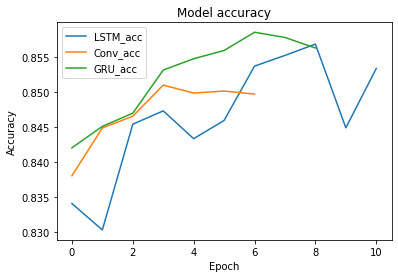

In [13]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_acc'], label='LSTM_acc')
plt.plot(history_1.history['val_acc'], label='Conv_acc')
plt.plot(history_2.history['val_acc'], label='GRU_acc')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


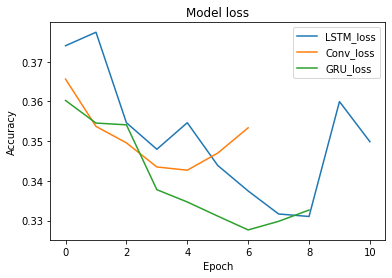

In [14]:
plt.plot(history.history['val_loss'], label='LSTM_loss')
plt.plot(history_1.history['val_loss'], label='Conv_loss')
plt.plot(history_2.history['val_loss'], label='GRU_loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [15]:
print((y_train==0).sum(), (y_train==1).sum())

72924 72215


In [16]:
#gensim==3.8.3
import gensim
word2vec_file_path = os.path.join(local_path, 'data', 'ko.bin')
word2vec_ko_model = gensim.models.Word2Vec.load(word2vec_file_path)
word2vec_ko_model.similar_by_word("자동차")

/tmp/ipykernel_1454/871729008.py:5: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec_ko_model.similar_by_word("자동차")


[('승용차', 0.729595422744751),
 ('스포츠카', 0.6468127965927124),
 ('오토바이', 0.6444642543792725),
 ('이륜차', 0.6432071328163147),
 ('자가용', 0.6401187777519226),
 ('경주용', 0.6348319053649902),
 ('미니밴', 0.6230480074882507),
 ('경차', 0.6184974908828735),
 ('현대자동차', 0.6122195720672607),
 ('자전거', 0.6117190718650818)]

In [17]:
word2vec_ko_model['자동차']

/tmp/ipykernel_1454/3941648477.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  word2vec_ko_model['자동차']


array([-2.1799444e-01,  7.4607009e-01,  9.9072278e-01,  8.5899860e-01,
       -9.7080368e-01, -5.5684823e-01,  1.7214289e+00, -6.7614257e-01,
        2.7608496e-01, -1.8445407e+00,  9.2257899e-01, -1.0389674e+00,
       -3.7929282e-01, -1.2692213e+00, -2.5065787e+00,  4.5063258e-03,
       -5.2440840e-01, -1.2708049e-01, -2.6658008e+00, -1.2863132e+00,
       -1.9656490e+00, -7.4687123e-01, -1.2433782e-01,  4.0630311e-01,
       -7.1055388e-01, -2.4316990e+00,  4.4966701e-01,  2.1234727e+00,
        1.9699278e+00,  8.5916567e-01,  2.7979857e-01,  5.9493303e-01,
       -1.7888557e+00,  1.4845309e+00,  7.4385089e-04,  6.6847461e-01,
       -1.4189643e+00, -1.5629472e+00,  7.7731383e-01, -8.6850345e-01,
        1.3043642e+00, -1.7911224e+00, -7.2049809e-01,  2.3248043e+00,
        5.5081940e-01,  3.3016291e-01,  7.5898960e-02, -7.4720092e-02,
       -1.6600585e+00, -1.5270574e+00, -2.1942817e-01, -7.3349804e-02,
       -1.9354802e+00,  5.7570595e-01, -2.6276556e-01, -2.3836954e+00,
      

In [18]:
from tqdm import tqdm
index_to_word = {index:word for word, index in word_to_index.items()}
x_train_ = np.zeros(len(x_train)*max_len*200).reshape(-1, max_len,200)
x_test_ = np.zeros(len(x_test)*max_len*200).reshape(-1, max_len,200)
for i in tqdm(range(len(x_train))):
    for j in range(len(x_train[i])):
        if x_train[i][j] == 0 or index_to_word[x_train[i][j]] not in word2vec_ko_model:
            continue
        x_train_[i][j] = word2vec_ko_model[index_to_word[x_train[i][j]]]
for i in tqdm(range(len(x_test))):
    for j in range(len(x_test[i])):
        if x_test[i][j] == 0 or index_to_word[x_test[i][j]] not in word2vec_ko_model:
            continue
        x_test_[i][j] = word2vec_ko_model[index_to_word[x_test[i][j]]]

  0%|          | 0/145139 [00:00<?, ?it/s]/tmp/ipykernel_1454/1429718414.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if x_train[i][j] == 0 or index_to_word[x_train[i][j]] not in word2vec_ko_model:
/tmp/ipykernel_1454/1429718414.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  x_train_[i][j] = word2vec_ko_model[index_to_word[x_train[i][j]]]
  0%|          | 0/48379 [00:00<?, ?it/s]/tmp/ipykernel_1454/1429718414.py:12: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if x_test[i][j] == 0 or index_to_word[x_test[i][j]] not in word2vec_ko_model:
/tmp/ipykernel_1454/1429718414.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  x_test_[i][j] = word2vec_ko_model[index_

In [19]:
model_2_ = tf.keras.Sequential()
model_2_.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_2_.add(tf.keras.layers.Dropout(0.2))
model_2_.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)))
model_2_.add(tf.keras.layers.Dropout(0.2))
model_2_.add(tf.keras.layers.Dense(16, activation='tanh'))
model_2_.add(tf.keras.layers.Dropout(0.2))
model_2_.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_2_.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               31488     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [ ]:
model_2_.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history_2_ = model_2_.fit(x_train_,
                    y_train,
                    epochs=15,
                    batch_size=2000,
                    validation_data=(x_test_, y_test),
                    verbose=1,
                    callbacks=[early_stopping])

In [ ]:
plt.plot(history.history['val_acc'], label='LSTM_acc')
plt.plot(history_1.history['val_acc'], label='Conv_acc')
plt.plot(history_2.history['val_acc'], label='GRU_acc')
plt.plot(history_2_.history['val_acc'], label='Word2Vec_GRU_acc')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['val_loss'], label='LSTM_loss')
plt.plot(history_1.history['val_loss'], label='Conv_loss')
plt.plot(history_2.history['val_loss'], label='GRU_loss')
plt.plot(history_2_.history['val_loss'], label='Word2Vec_GRU_loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

model_2_.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history_2_ = model_2_.fit(x_train,
                    y_train,
                    epochs=15,
                    batch_size=64,
                    validation_data=(x_test, y_test),
                    verbose=1,
                    callbacks=[early_stopping])